#Introduction to Machine Learning - Sharif University of Technology, Fall 2020

# Clustering (Kmeans , Gaussian Mixture Model) and EM algorithm - GMM (Part 2)


__content creator:__ Aryan Mikaeili

# Notebook Objective

Up until now, you have been introduced to and worked with Supervised learning methods. In this method of learning the goal is clear; to produce desired output, given a set of inputs. However from now on, we want to explore another method of learning, namely Unsupervised learning. this method can be categorized as follows:
1. Clustering 
2. Dimensionality reduction
3. Data density estimation
4. finding a hidden cause

In the previous notebook, we went over the Kmeans algorithm. Although Kmeans is a simple and good way to approach clustering, It does not always work properly. For example let's try to cluster the data below using Kmeans.


In [ ]:
#@title Imports: Please run this cell to set notebooks environment

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
#@title Helper functions

def find_distance(x, y):

  """ please do not edit this function """

  ##################################Inputs##################################
  # x : (N1 * f) ndarray
  # y : (N2 * f) ndarray
  ##########################################################################

  ##################################Outputs##################################
  #o:  (N1 * N2) ndarray , o[i, j] is the distance of x[i] and y[j] squared
  ##########################################################################

  k = y.shape[0]
  data_size = x.shape[0]

  x_norm = np.repeat(np.expand_dims(np.linalg.norm(x, axis = 1) ** 2, 1), k, axis = 1)
  y_norm = np.repeat(np.expand_dims(np.linalg.norm(y, axis = 1) ** 2, 0), data_size, axis = 0)
  x_y_inner = np.matmul(x, y.T)

  o = x_norm + y_norm - 2 * x_y_inner
  return o

class Kmeans:

  def __init__(self, x, k, max_iters = 1000):
    self.x = x
    self.data_size = x.shape[0]
    self.feature_size = x.shape[1]
    self.k = k
    self.max_iters = max_iters

    self.centers = np.zeros((k, x.shape[1]))
  
    self.predictions = np.zeros(self.data_size)



  def Kmeans_plus_plus(self):
    centers = np.zeros((self.k, self.feature_size))
  
    centers[0] = random.choices(self.x)[0]

    for i in range(1, self.k):
      current_centers = centers[: i]
      data_center_dists = find_distance(self.x, current_centers)

      min_dists = data_center_dists.min(axis = 1)
      centers[i] = random.choices(self.x, weights = min_dists)[0]
    return centers

  def random_init(self):
      mean = np.mean(self.x, axis = 0)
      std = np.std(self.x, axis = 0)

      centers = np.random.randn(self.k, self.feature_size) * mean + std

      return centers


  def predict(self, init_mode = 'random'):

    if init_mode == 'random':
      self.centers = self.random_init()
    elif init_mode == 'kmeans++':
      self.centers = self.Kmeans_plus_plus()
    for i in range(self.max_iters):
      data_center_dists = find_distance(self.x, self.centers)
      self.predictions = data_center_dists.argmin(axis = 1)

      prev_centers = np.copy(self.centers)

      for j in range(self.k):
        cluster_j = self.x[self.predictions == j] 
        if len(cluster_j) > 0:
          self.centers[j] = cluster_j.mean(axis = 0)
      
      if (prev_centers == self.centers).all():
        return


  def calc_distortion(self):
    distortion = 0

    for i in range(self.k):
      cluster_x = self.x[self.predictions == i]
      cluster_center = self.centers[i]
      if len(cluster_x) > 0:
        cluster_distances = find_distance(cluster_x, np.expand_dims(cluster_center, 0))

        distortion += cluster_distances.sum()
    
    return distortion / self.data_size


from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(cov, mean_x, mean_y, ax, n_std=3.0, facecolor='none', **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

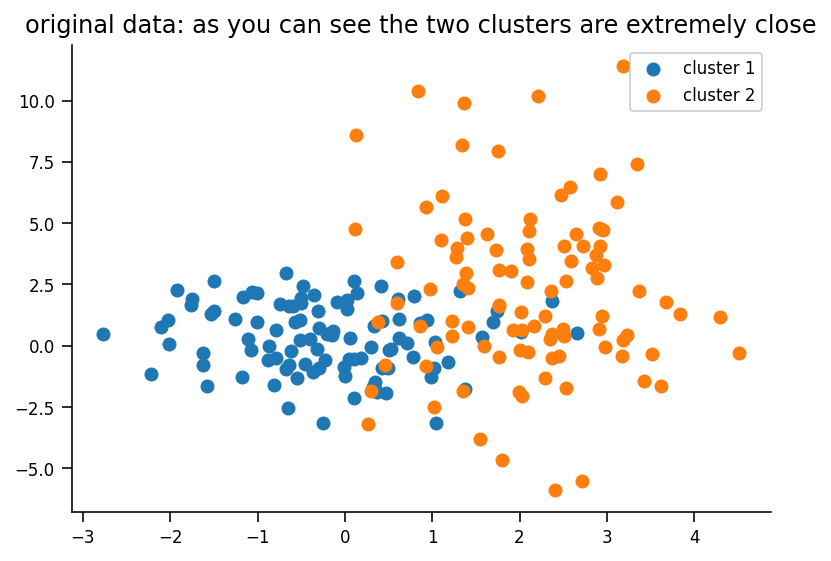

In [ ]:
#@title Data Generation

cluster1 = np.random.multivariate_normal([0, 0], [[1, 0],[0, 2]], 100)
cluster2 = np.random.multivariate_normal([2,2], [[1, 0],[0, 10]], 100)

data = np.row_stack([cluster1, cluster2])

plt.scatter(cluster1[:, 0], cluster1[:, 1])
plt.scatter(cluster2[:, 0], cluster2[:, 1])

plt.legend(['cluster 1', 'cluster 2'])
plt.title('original data: as you can see the two clusters are extremely close')
plt.show()

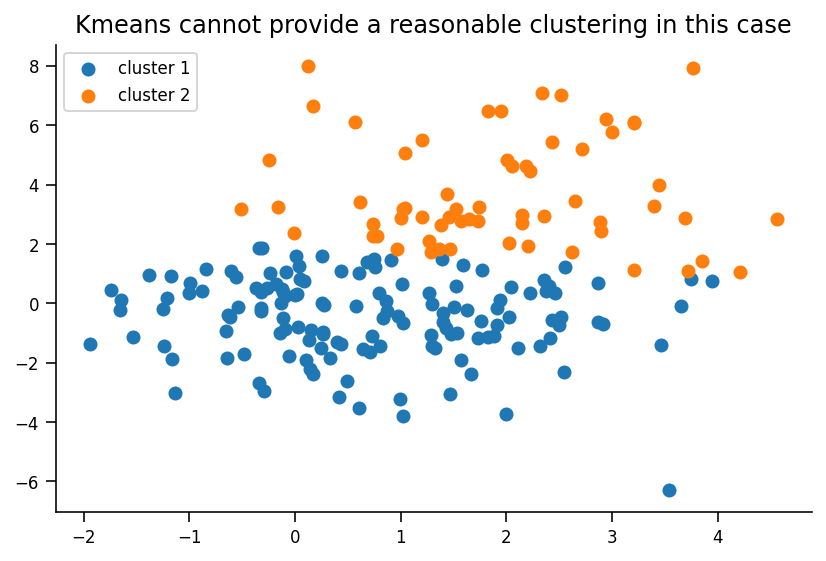

In [ ]:
model = Kmeans(data, 2)


model.predict('kmeans++')

plt.scatter(data[model.predictions == 0, 0], data[model.predictions == 0, 1])
plt.scatter(data[model.predictions == 1, 0], data[model.predictions == 1, 1])

plt.legend(['cluster 1', 'cluster 2'])
plt.title('Kmeans cannot provide a reasonable clustering in this case')
plt.show()


As a result we should come up with smarter ways to do clustering.

In this Notebook, we Introduce Gaussian Mixture Models (GMMs); In which we assume that the whole data comes from a mixture of __k__ gaussian distributions and our goal is to find a way to estimate the parameters of these distributions. In summary, in this notebook we will:
1. Review GMMs and formulize the problem
2. implement GMM


# Introduction

As you recall, in the GMM model, we try to fit __k__ gaussian distributions to the set of datapoints we have. and oure goal is to estimate the parameters, i.e. the mean and the covariance matrix of these gaussian distribution.

Let's assume we have a distribution __z__ which has a 1-of-K representation; meaning that it is a k dimensional binary vector, with ony a 1 and the rest zero and the 1 indicates from which gaussian distribution a datapoint comes from. That means that $z$ is a distribution with k states.

now we can write:

$$p(z_k = 1) = \pi_k$$

$\pi_k$ being a variable satisfying $\sum_k{\pi_k} = 1$.

So we have:
$$ p(z) = \prod_k{\pi_k^{z_k}}$$

we also have:

$$ p(x|z) = \sum_k{\mathbb{N}(x | \mu_k, \Sigma_k) ^ z_k} $$

As a result if we want to write the marginal distribution of $p(x)$, we have to write:

$$p(x) = \sum_k{p(x|z)p(z)} =  \sum_k{\pi_k \mathbb{N}(x | \mu_k, \Sigma_k)}$$

To estimate the parameters of the Gaussians, we will first write the maximum log-likelihood of the data.

$$\log p(X|z, \theta) = \sum_n{\log{\sum_k{\pi_k \mathbb{N}(x | \mu_k, \Sigma_k)}}}$$

Now had it been the case that we had a single gaussian, we would have simply calculated the derivative of this function with respect to the parmaters ($\theta$) and calculated the optimum parameters. But in this case we cannot do that because of singularities. Assume that one of the gaussians collapses into a single datapoint. i.e. the mean of the gaussian becomes equal to the datapoint and the standard deviations becomes zero. So the result of $\mathbb{N}(x | \mu_k, \Sigma_k)$ would be  infinity for this particular datapoint and as a result the log-likelihood of the data will tend to infinity. As mentioned before if we had a single gaussian distribution and this collapse happened, the probabilty of the other datapoints would have been equal to zero. So the probability of the whole data would have been zero.

Because of the problem mentioned above, to estimate the parameters of a GMM, we cannot use log-likelihood estimation. Instead, we use the EM algorithm. which is an algorithm that by maximizing another function (called variational lower bound) ensures that the log-likelihood function decreases too.

The details of the EM algorithm in general would be the topic of discussion for the next notebook. however, this algorithm, comes very naturally when solving the GMM problem.

# EM algorithm for GMM

Before we dive into the EM algorithm, we first calculate $p(z_k = 1|x_n, \theta)$ and call it $\gamma_n(z_k)$. Because this would come in handy in the steps of the EM algorithm.

Using the Bayes rule we have:

$$p(z_k = 1|x_n, theta) =  \frac{p(x_n|z_k = 1, \theta) p(z_k = 1|\theta)}{p(x_n|\theta)} =  \frac{p(x_n|z_k = 1, \theta) p(z_k = 1|\theta)}{\sum_j{p(x_n|z_j = 1)p(z_j = 1)}} = \frac{\pi_k \mathbb{N}(x | \mu_k, \Sigma_k)}{\sum_j{\pi_j \mathbb{N}(x | \mu_j, \Sigma_j)}}$$

Now that we have caluclated everything that we need, we will solve the GMM problem.
We first need to estimate the $\mu_k$ parameters. For that, we take the derivative of the log_likelihood function with respect to $\mu_k$ and set it to zero. So we will have:

$$0 = \sum_n\;\underbrace{\frac{\pi_k \mathbb{N}(x | \mu_k, \Sigma_k)}{\sum_j{\pi_j \mathbb{N}(x | \mu_j, \Sigma_j)}}}_{\gamma_n(z_k)}\Sigma_k(x_n - \mu_k) \Rightarrow \mu_k = \frac{1}{N_k}\sum_n{\gamma_n(z_k)x_n} $$

In the final result, $N_k = \sum_n{\gamma_n(z_k)}$.

As you can understand, the phrase which is equal to $\gamma_n(z_k)$ has $\mu_k$ in it. but this simplifying assumption that this phrase is constant and equal to $\gamma_n(z_k)$ is how the EM algorithm approaches this problem.

For the other parameters also, we can simply derive that:

$$\Sigma_k = \frac{1}{N_k}\sum_n{\gamma_n(z_k)(x_n - \mu_k)(x_n - \mu_k)^T}$$
$$\pi_k = \frac{N_k}{N}$$

in which $N$ is the total number of datapoints.

In summary the EM algorithm has two steps:
1. the Expectation step (E step): calculate the $\gamma_n(z_k)$s.
2. the Maximization step (M step): maximize the log-likelihood function using the equations above.

in the next notebook we will in detail see that why this algorithm works and extend it for further use in other applications.




# Implementation

Now using the equations provided above, we will try to implement the Gaussian Mixture Model.

In [ ]:
from scipy.stats import multivariate_normal

class GMM:
  def __init__(self, x, k, max_iter = 1000, threshold = 1e-4):
    ##################################Inputs##################################
    # x: the data we are clustering, a (N * k) ndarray
    # k: number of clusters
    # max_iter: the maximum number of iteration before aborting the algorithm
    # threshold: abort algorithm if negative log-likelihoods change is below this threshold
    ##########################################################################
    self.x = x
    #number of datapoints    
    self.data_size = self.x.shape[0]

    #dimension of the space
    self.feature_size = self.x.shape[1]
    
    self.k = k

    self.max_iter = max_iter

    self.threshold = threshold

    #the final clustering result
    self.predictions = np.zeros(self.data_size)

    #parameters of the model
    self.Pi = None
    self.Mu = None
    self.Sigma = None

    #gamma or p(z|x)
    self.gammas = np.zeros((self.data_size, self.k))
  
  def init_params(self):

  ###############################################################################
    ## Insert your code here to:
    #   * Initalizes Parameters of Model. i.e. Mu, Sigma and Pi.
    #   * Mu: randomly chosen among datapoints
    #   * Sigma: Identity Matrix
    #.  * Pi: Uniform. probability of data coming from each cluster is equal

    raise NotImplementedError("Please complete This part")
    ###############################################################################
    
    self.Pi = ...

    self.Mu = ...

    self.Sigma =  ...

  
  def calc_gammas(self):

  ###############################################################################
    ## Insert your code here to:
    #   * Calculate gammas
    raise NotImplementedError("Please complete This part")
    ###############################################################################

  def update_mu(self, N_k):
    ##################################Inputs##################################
    # N_k: sum of gamma(n, k) over n
    ##########################################################################

    ###############################################################################
    ## Insert your code here to:
    #   * update Mu
    raise NotImplementedError("Please complete This part")
    ###############################################################################


  def update_sigma(self, N_k):
    ##################################Inputs##################################
    # N_k: sum of gamma(n, k) over n
    ##########################################################################

    ###############################################################################
    ## Insert your code here to:
    #   * update Sigma
    raise NotImplementedError("Please complete This part")
    ###############################################################################

  def update_pi(self, N_k):
    ##################################Inputs##################################
    # N_k: sum of gamma(n, k) over n
    ##########################################################################

    ###############################################################################
    ## Insert your code here to:
    #   * update Pi
    raise NotImplementedError("Please complete This part")
    ###############################################################################


  #the following 3 functions are for calculating log-likelihood
  def calc_nmat(self):
     diff = np.reshape(self.x, (self.data_size, 1, self.feature_size)) - np.reshape(self.Mu, (1, self.k, self.feature_size))
     L = np.linalg.inv(self.Sigma)
     exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", diff, L), diff)
     Nmat = np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(self.Sigma))   / ((2 * np.pi) ** (self.feature_size/2))

     return Nmat

  
  def calc_probability(self):
    nmat = self.calc_nmat()

    probs = nmat @ self.Pi

    return probs

  def calc_log_likelihood(self):
    probs = self.calc_probability()

    log_prob = np.log(probs)

    nll = -np.sum(log_prob)

    return nll

  def predict(self):

    ###############################################################################
    ## Insert your code here to:
    #.  * Initialize Parameters
    #   * Perform the E step
    #   * Perform the M step
    #   * determine cluster of each datapoint
  
    raise NotImplementedError("Please complete This part")
    ###############################################################################

    #Initialize Parameters

    ...

    #negative log_likelihood initialization

    nll = np.inf

    for i in range(self.max_iter):
      #E step
      ...

      #M_step

      ...

      # algorithm abortion criteria
      old_nll = nll

      nll = self.calc_log_likelihood()

      if old_nll - nll < self.threshold:
        break     
   

      

    #determine each datapoints cluster
    ...




In [ ]:
#@title click to view solution or run the cell
from scipy.stats import multivariate_normal

class GMM:
  def __init__(self, x, k, max_iter = 1000, threshold = 1e-4):
    ##################################Inputs##################################
    # x: the data we are clustering, a (N * k) ndarray
    # k: number of clusters
    # max_iter: the maximum number of iteration before aborting the algorithm
    # threshold: abort algorithm if negative log-likelihoods change is below this threshold
    ##########################################################################
    self.x = x
    #number of datapoints    
    self.data_size = self.x.shape[0]

    #dimension of the space
    self.feature_size = self.x.shape[1]
    
    self.k = k

    self.max_iter = max_iter

    self.threshold = threshold

    #the final clustering result
    self.predictions = np.zeros(self.data_size)

    #parameters of the model
    self.Pi = None
    self.Mu = None
    self.Sigma = None

    #gamma or p(z|x)
    self.gammas = np.zeros((self.data_size, self.k))
  
  def init_params(self):
    self.Pi = np.ones(self.k) / self.k

    self.Mu = self.x[np.random.choice(self.data_size, self.k, replace = False)]

    self.Sigma =  np.repeat(np.expand_dims(np.eye(N = self.feature_size), 0), self.k , axis = 0)

  def calc_nmat(self):
     diff = np.reshape(self.x, (self.data_size, 1, self.feature_size)) - np.reshape(self.Mu, (1, self.k, self.feature_size))
     L = np.linalg.inv(self.Sigma)
     exponent = np.einsum("nkj,nkj->nk", np.einsum("nki,kij->nkj", diff, L), diff)
     Nmat = np.exp(-0.5 * exponent) / np.sqrt(np.linalg.det(self.Sigma))   / ((2 * np.pi) ** (self.feature_size/2))

     return Nmat
  
  def calc_probability(self):
    nmat = self.calc_nmat()

    probs = nmat @ self.Pi

    return probs

  def calc_log_likelihood(self):
    probs = self.calc_probability()

    log_prob = np.log(probs)

    nll = -np.sum(log_prob)

    return nll


  def calc_gammas(self):

    for i in range(self.data_size):
      for j in range(self.k):
          self.gammas[i, j] = self.Pi[j] * multivariate_normal.pdf(self.x[i], self.Mu[j], self.Sigma[j])
    
      self.gammas[i] = self.gammas[i] / self.gammas[i].sum()

  def update_mu(self, N_k):
    self.Mu = (1 / N_k).reshape(-1, 1) * np.matmul(self.gammas.T, self.x) 

  def update_sigma(self, N_k):
    diff = np.reshape(self.x, (self.data_size, 1, self.feature_size)) - np.reshape(self.Mu, (1, self.k, self.feature_size))

    self.Sigma = np.einsum('nki, nkj->kij', np.einsum('nk, nki -> nki', self.gammas, diff), diff) / np.reshape(N_k, (self.k, 1, 1))
  def update_pi(self, N_k):
    self.Pi = N_k / self.data_size

  def predict(self):
    self.init_params()

    nll = np.inf
    for i in range(self.max_iter):
      #E step
      self.calc_gammas()

      #M_step

      N_k = np.sum(self.gammas, axis = 0)

      self.update_mu(N_k)
      self.update_sigma(N_k)
      self.update_pi(N_k)

      old_nll = nll

      nll = self.calc_log_likelihood()
      if old_nll - nll < self.threshold:
        break     

      

    self.predictions = np.argmax(self.gammas, axis = 1)



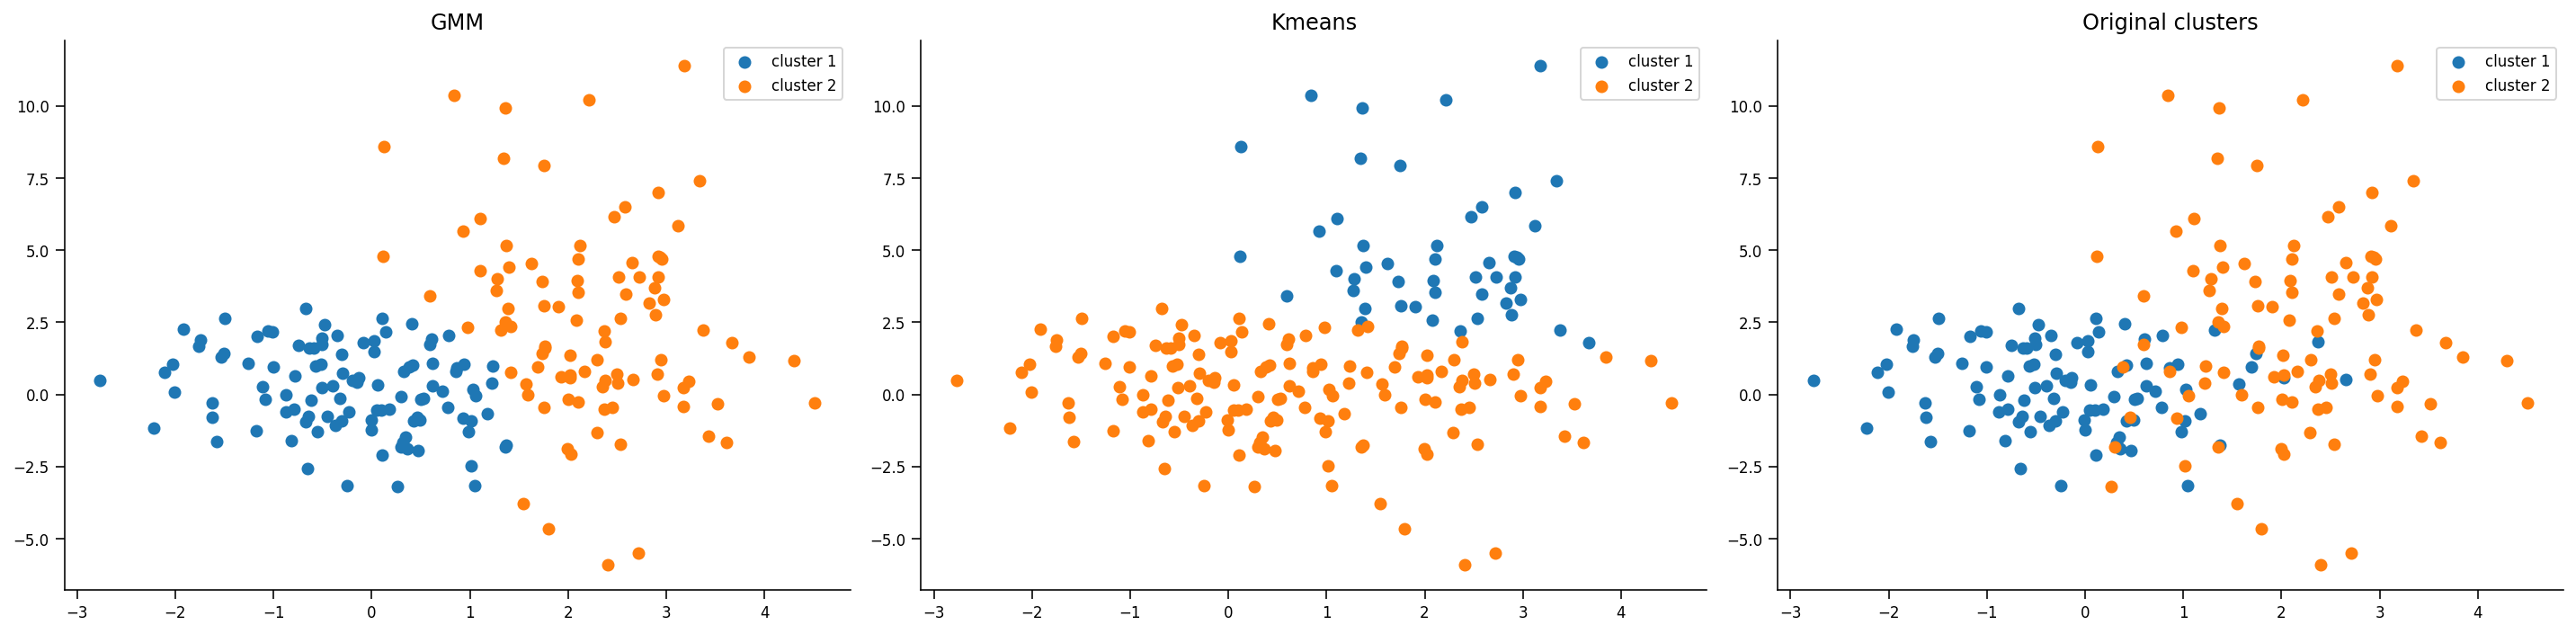

In [ ]:
model = GMM(data, 2, max_iter = 100)
model.predict()


fig, axs = plt.subplots(1, 3, figsize = (20, 5))

axs[0].scatter(data[model.predictions == 0, 0], data[model.predictions == 0, 1])
axs[0].scatter(data[model.predictions == 1, 0], data[model.predictions == 1, 1])

axs[0].legend(['cluster 1', 'cluster 2'])

axs[0].set_title('GMM')


model = Kmeans(data, 2)
model.predict('kmeans++')
axs[1].scatter(data[model.predictions == 0, 0], data[model.predictions == 0, 1])
axs[1].scatter(data[model.predictions == 1, 0], data[model.predictions == 1, 1])

axs[1].legend(['cluster 1', 'cluster 2'])

axs[1].set_title('Kmeans')

axs[2].scatter(cluster1[:, 0], cluster1[:, 1])
axs[2].scatter(cluster2[:, 0], cluster2[:, 1])

axs[2].legend(['cluster 1', 'cluster 2'])

axs[2].set_title('Original clusters')

plt.show()


Now let's see how the gaussians that our model predicted actually look like in the plot. The ellipses plotted are the confidence ellipses of the data. with center on the mean of the corresponing gaussian and radius proportional to variance of data in x and y direction.


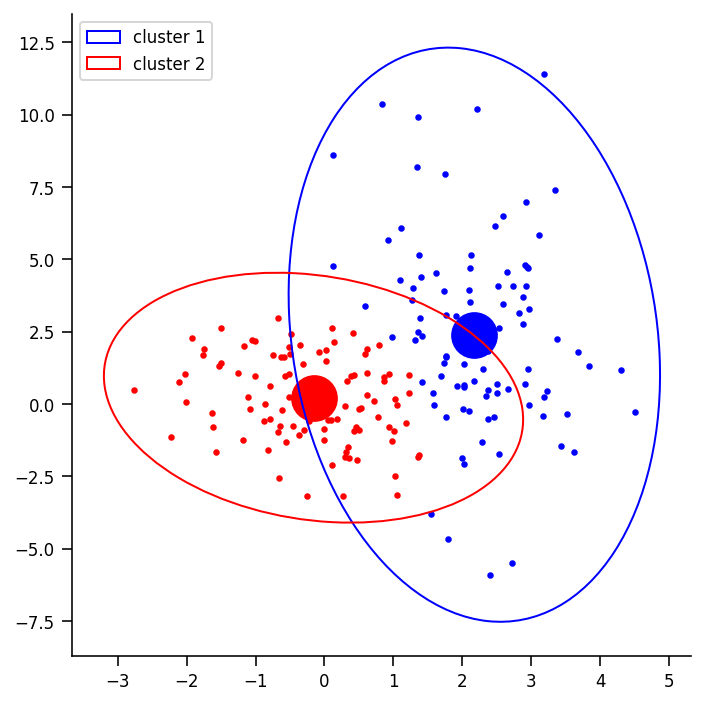

In [ ]:
model = GMM(data, 2, max_iter = 100)
model.predict()

fig, axs = plt.subplots(figsize = (5,  5))

axs.scatter(data[model.predictions == 0, 0], data[model.predictions == 0, 1], s = 5, c = 'blue')
axs.scatter(model.Mu[0][0], model.Mu[0][1], s = 500, marker = 'o', c = 'blue')
confidence_ellipse(model.Sigma[0], model.Mu[0][0], model.Mu[0][1], axs, edgecolor = 'blue')

axs.scatter(data[model.predictions == 1, 0], data[model.predictions == 1, 1], s = 5, c = 'red')
axs.scatter(model.Mu[1][0], model.Mu[1][1], s = 500, marker = 'o', c = 'red')
confidence_ellipse(model.Sigma[1], model.Mu[1][0], model.Mu[1][1], axs, edgecolor = 'red')

axs.legend(['cluster 1', 'cluster 2'])
plt.show()